In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
import cartopy.feature as cfeature
from os.path import join
import os
from evml.keras.models import EvidentialRegressorDNN, CategoricalDNN, calc_prob_uncertainty
import yaml
from bridgescaler import load_scaler
from scipy.ndimage import gaussian_filter
%matplotlib inline

In [2]:
def prepare_rap_data(base_path, start, end, levels, scaler_obj):
    
    dates = pd.date_range(start, end, freq='H').strftime("%Y%m%d")
    times = pd.date_range(start, end, freq='H').strftime("%H00")
    file_names = [os.path.join(base_path, dates[x], f"rap_130_{dates[x]}_{times[x]}_000.nc") for x in range(len(dates))]
    variables = ['TMP', 'T_DEWPOINT', 'UGRD', 'VGRD', 'time']
    data = xr.open_mfdataset(file_names)[variables].load()
    lat = np.tile(data['latitude'].values.flatten(), data.time.size)
    lon = np.tile(data['longitude'].values.flatten(), data.time.size)
    time = data['time'].values.flatten()
    
    dfs = []
      
    for i, level in enumerate(levels):
        if  (i % 10) == 0:
            print(i)
        # height = data['height'][i].values
        height = level
        renamed = {"TMP": f"TEMP_C_{height}_m", "T_DEWPOINT": f"T_DEWPOINT_C_{height}_m", "UGRD": f"UGRD_m/s_{height}_m", "VGRD": f"VGRD_m/s_{height}_m"}
        df = data.sel(height=level).reset_coords()[variables].rename_vars(renamed).to_dataframe().reset_index(level=['x', 'y'], drop=True)
        dfs.append(df)
    
    reformatted_data = pd.concat(dfs,axis=1)
    reformatted_data['latitude'] = lat
    reformatted_data['longitude'] = lon
    reformatted_data = reformatted_data.reset_index().set_index(['time', 'longitude', 'latitude'])
    
    tmp = [x for x in list(reformatted_data.columns) if 'TEMP' in x]
    dwpt = [x for x in list(reformatted_data.columns) if 'DEWPOINT' in x]
    ugrd = [x for x in list(reformatted_data.columns) if 'UGRD' in x]
    vgrd = [x for x in list(reformatted_data.columns) if 'VGRD' in x]
    features = tmp + dwpt + ugrd + vgrd
    
    model_input = scaler_obj.transform(reformatted_data[features])
    
    return data, reformatted_data, model_input

In [3]:
# %%time
# start = "2016-12-17-0000"
# end = "2016-12-19-0000"
# path = '/glade/p/cisl/aiml/conv_risk_intel/rap_ncei_nc'
# dates = pd.date_range(start, end, freq='h').strftime("%Y%m%d")
# datetimes = pd.date_range(start, end, freq='h').strftime("%Y%m%d_%H00")
# files = [join(path, date, f'rap_130_{datetime}_000.nc') for date, datetime in zip(dates, datetimes)]

# rap = xr.open_mfdataset(files)

In [3]:
start = "2016-12-17-0000"
end = "2016-12-17-0000"
base_path = "/glade/p/cisl/aiml/conv_risk_intel/rap_ncei_height/"
levels = np.arange(0, 5250, 250)
scaler = load_scaler("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/evidential/scalers/input.json")
ds, df, model_input = prepare_rap_data(base_path, start, end, levels, scaler)

0
10
20


In [4]:
with open("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/evidential/best.yml") as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)
model = CategoricalDNN().load_model(conf)

2023-08-21 15:14:52.064404: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
%%time
preds, evi, ale, epi = model.compute_uncertainties(model.predict(model_input, batch_size=10000))

labels = preds.numpy().argmax(axis=1)
rows = np.arange(len(preds.numpy()))
probability = preds.numpy()[rows, labels]
all_al = ale.numpy().sum(axis=1)
aleatoric = ale.numpy()[rows, labels]
all_ep = epi.numpy().sum(axis=1)
epistemic = epi.numpy()[rows, labels]
all_evi = evi.numpy()
evidential = evi.numpy()[rows]

CPU times: user 1min 27s, sys: 1.25 s, total: 1min 29s
Wall time: 46.5 s


In [6]:
df['Class'] = labels
# df['RAP Class'] = rap_class
df['Probability'] = probability
df['Aleatoric'] = np.sqrt(aleatoric)
df['Epistemic'] = np.sqrt(epistemic)
df['all_ep'] = np.sqrt(all_ep)
df['all_al'] = np.sqrt(all_al)
df['Evidential'] = evidential
df['all_evi'] = all_evi

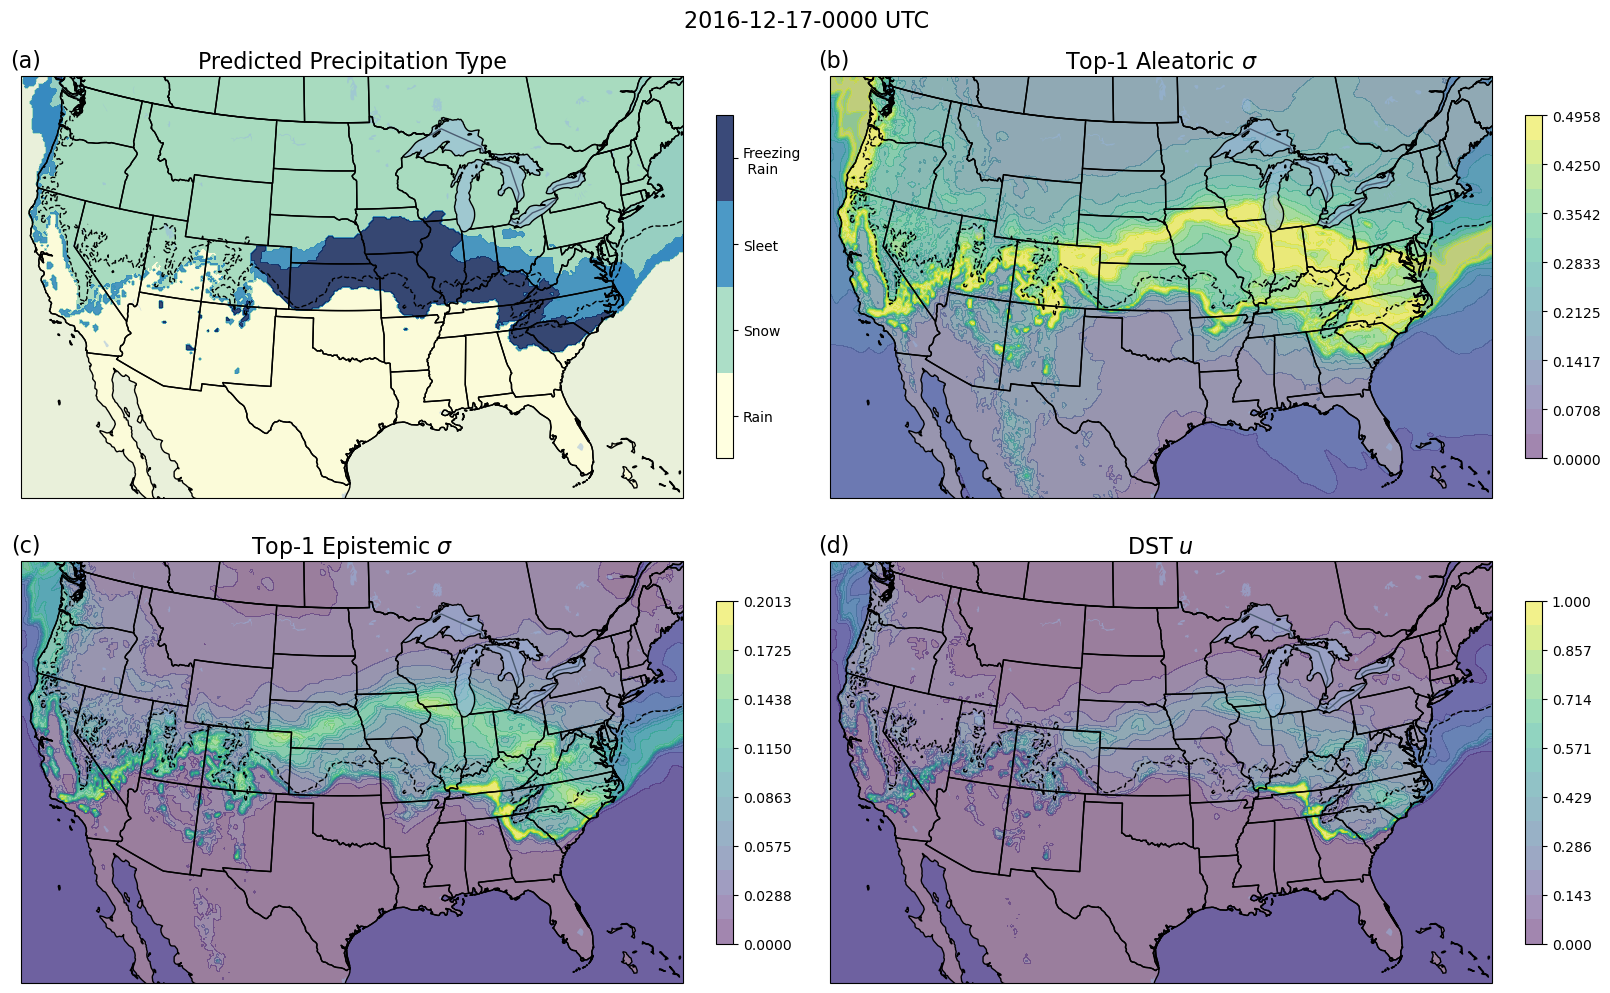

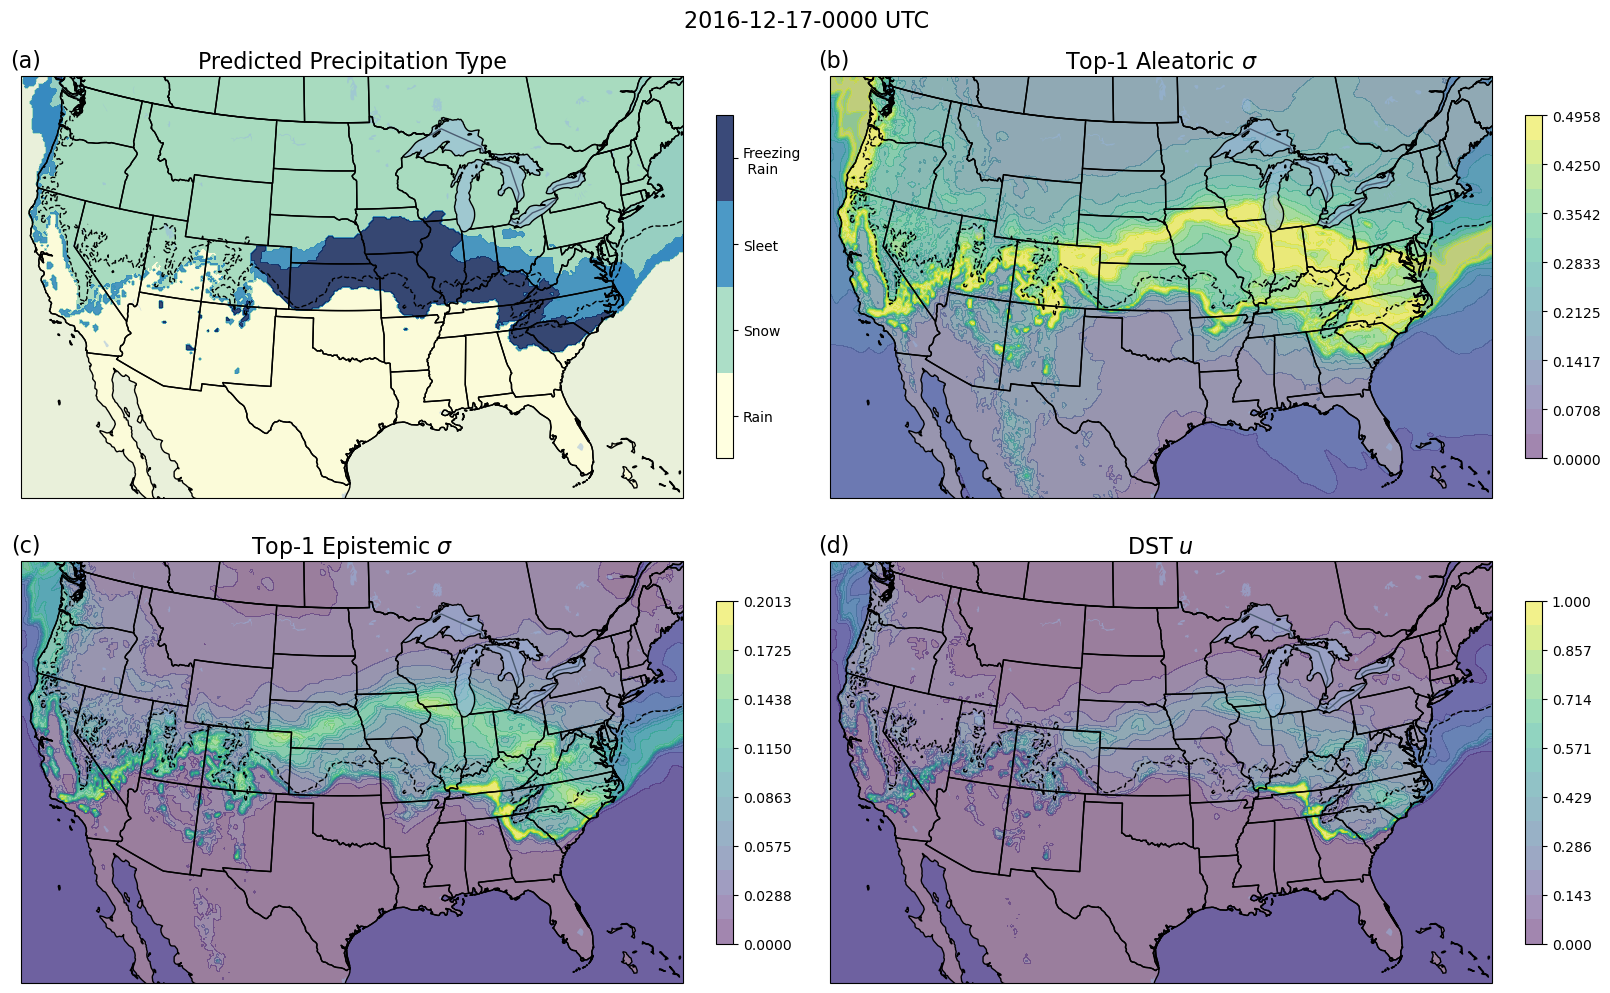

In [9]:
lon, lat = ds.longitude, ds.latitude
columns = ["Class", "Aleatoric", "Epistemic", "Evidential"]
leg_columns = ["Class", r"Top-1 Aleatoric $\sigma$", r"Top-1 Epistemic $\sigma$", r"DST $u$"]
captions = ["(a)", "(b)", "(c)", "(d)"]

lcc = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig = plt.figure(figsize=(16, 10), constrained_layout=True)
for i in range(4):
    
    ax = fig.add_subplot(2, 2, i + 1, projection=lcc)
    ax.set_extent([-120, -74, 25, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    
    data = df[columns[i]].values.reshape(lon.shape)
    ax.contour(lon, lat, ds["TMP"][0, 0], transform=ccrs.PlateCarree(), linewidths=1, linestyles="--", colors='k', levels=[0])
    
    if i == 0:
        cmap = plt.get_cmap('YlGnBu', 4)
        p = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), alpha=0.8, cmap=cmap, levels=[-0.5, 0.5, 1.5, 2.5, 3.5])
        ax.set_title("Predicted Precipitation Type", fontsize=16)
        cbar = plt.colorbar(p, shrink=0.75, ax=ax)
        cbar.set_ticks(ticks=[0, 1, 2, 3])
        cbar.set_ticklabels(ticklabels=['Rain', 'Snow', 'Sleet', 'Freezing\n Rain'])
    else:
        p = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), alpha=0.5, vmin=0, vmax=data.max(), cmap='viridis', levels=np.linspace(0, data.max(), 15))
        # ax.contour(lon, lat, ds["TMP"][0, 0], transform=ccrs.PlateCarree(), linewidths=0.5, colors='k', levels=np.linspace(-10, 10, 20))   # add multiuple temperature contours
        ax.set_title(leg_columns[i], fontsize=16)
        cbar = plt.colorbar(p, ax=ax, shrink=0.75)
    
    ax.text(0.03, 1.065, captions[i], transform=ax.transAxes, fontsize=16, va='top', ha='right')
    
    
fig.suptitle(f"{start} UTC", fontsize=16)

    
plt.savefig("ptype_evidential_uncertainties.png", dpi=300, bbox_inches="tight")

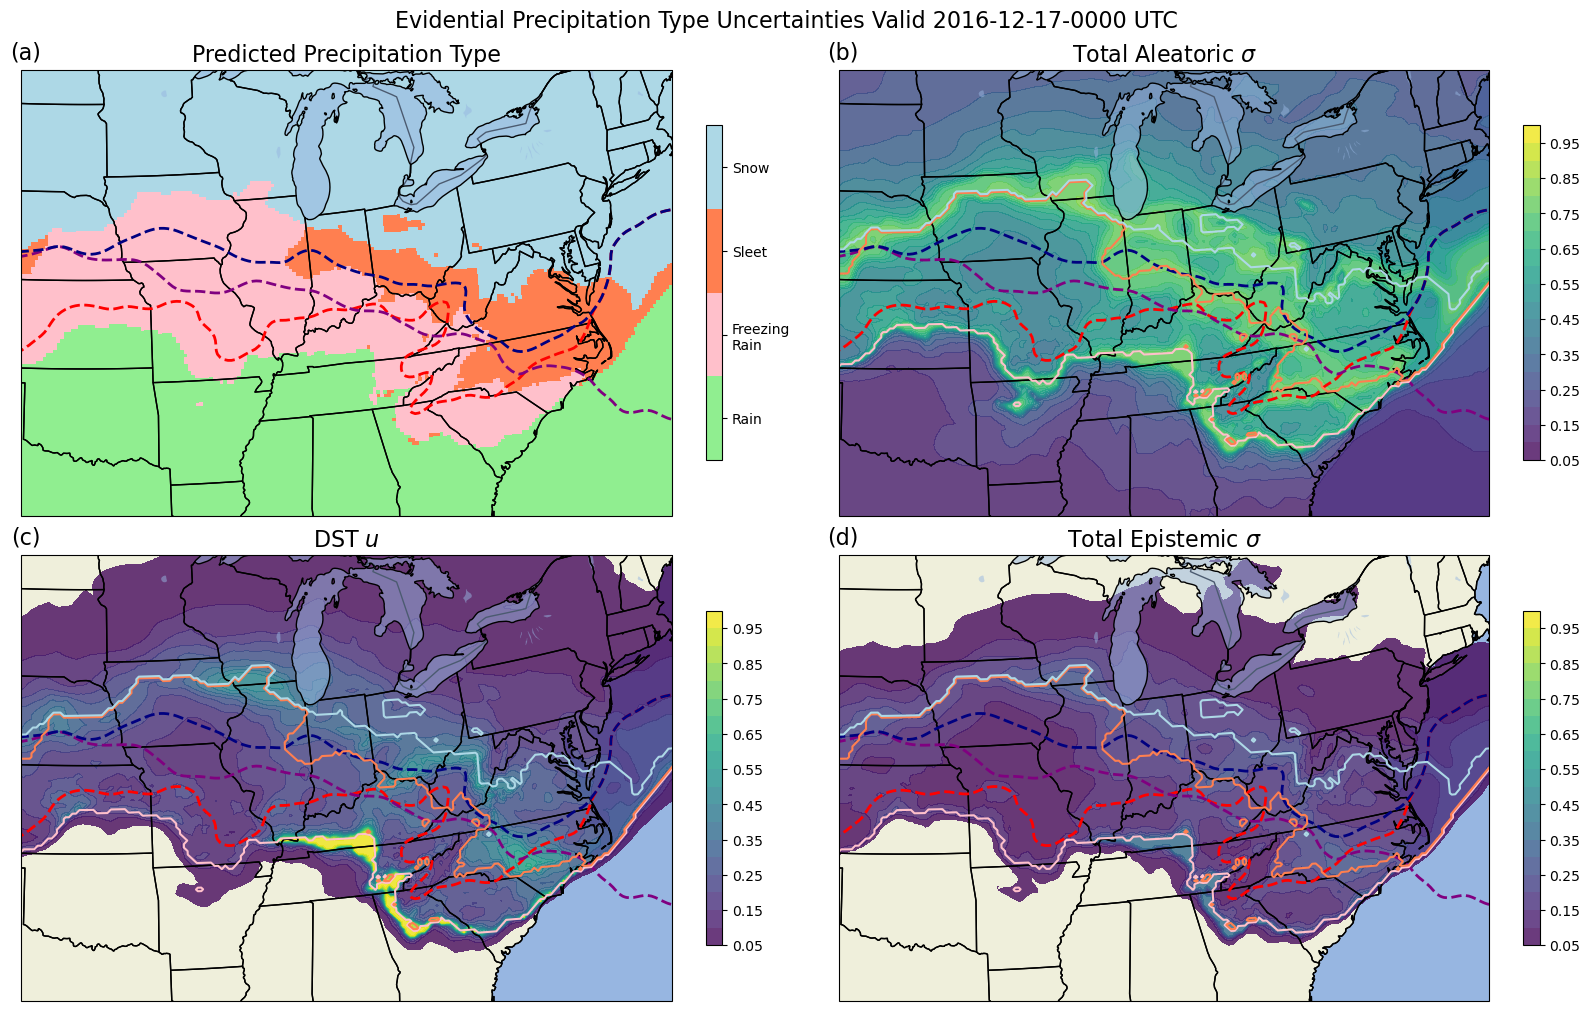

In [63]:
lon, lat = ds.longitude, ds.latitude
columns = ["Class", "all_al", "Evidential", "all_ep"]
leg_columns = ["Class", r"Total Aleatoric $\sigma$", r"DST $u$", r"Total Epistemic $\sigma$", ]
captions = ["(a)", "(b)", "(c)", "(d)"]

lcc = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig = plt.figure(figsize=(16, 10), constrained_layout=True)
surface_temp = gaussian_filter(ds["TMP"][0, 0], 2)
temp_2k = gaussian_filter(ds["TMP"][0, 8], 2)
temp_max = gaussian_filter(ds["TMP"][0].max(axis=0), 2)
for i in range(4):
    
    ax = fig.add_subplot(2, 2, i + 1, projection=lcc)
    ax.set_extent([-100, -74, 32, 45], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    
    data = df[columns[i]].values.reshape(lon.shape)
    ax.contour(lon, lat, surface_temp, transform=ccrs.PlateCarree(), linewidths=2, linestyles="--", colors='red', levels=[0])
    ax.contour(lon, lat, temp_2k, transform=ccrs.PlateCarree(), linewidths=2, linestyles="--", colors='purple', levels=[0,])
    ax.contour(lon, lat, temp_max, transform=ccrs.PlateCarree(), linewidths=2, linestyles="--", colors='navy', levels=[0,])

    if i == 0:
        #cmap = plt.get_cmap('YlGnBu', 4)
        cmap = ListedColormap(["lightgreen", "pink", "coral", "lightblue"])
        p = ax.pcolormesh(lon, lat, ptype_new, transform=ccrs.PlateCarree(), alpha=1, cmap=cmap, vmin=0, vmax=4)
        ax.set_title("Predicted Precipitation Type", fontsize=16)
        cbar = plt.colorbar(p, shrink=0.75, ax=ax)
        cbar.set_ticks(ticks=[0.5, 1.5, 2.5, 3.5])
        cbar.set_ticklabels(ticklabels=['Rain', 'Freezing\nRain', 'Sleet', 'Snow'])
    else:
        ax.contour(lon, lat, ptype_new, transform=ccrs.PlateCarree(), levels=[0.5, 1.5, 2.5, 3.5, 4.5], alpha=1, cmap=cmap, vmin=-1, vmax=3)
        p = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), alpha=0.8, vmin=0.05, vmax=1, 
                        cmap='viridis', levels=np.arange(0.05, 1.05, 0.05))
        # ax.contour(lon, lat, ds["TMP"][0, 0], transform=ccrs.PlateCarree(), linewidths=0.5, colors='k', levels=np.linspace(-10, 10, 20))   # add multiuple temperature contours
        ax.set_title(leg_columns[i], fontsize=16)
        cbar = plt.colorbar(p, ax=ax, shrink=0.75)
    
    ax.text(0.03, 1.065, captions[i], transform=ax.transAxes, fontsize=16, va='top', ha='right')
    
    
fig.suptitle(f"Evidential Precipitation Type Uncertainties Valid {start} UTC", fontsize=16)

    
plt.savefig("ptype_evidential_uncertainties.png", dpi=300, bbox_inches="tight")


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [56]:
ptype_old = df[columns[0]].values.reshape(lon.shape)
ptype_new = np.zeros(lon.shape)
ptype_new[ptype_old == 1] = 3
ptype_new[ptype_old == 2] = 2
ptype_new[ptype_old == 3] = 1

In [53]:
ptype_new.shape

(337, 451)